# Cox process per COVID-19 strain

Because of different nature of each COVID-19 strain data we estimate a stochastic process for each variant. We estimate the parameter $\alpha_{k_r}$ and we consider reinfection, therefore, we restart the dynamic at the beginning of each strain.

## Pre-processing

We get `NUEVO LEÓN` data and $R_t$ covariable. The $R_t$ estimation considers different epidemiology variables for each strain.

In [1]:
# Paths for Data and Library
import os
import numpy as np
import pandas as pd
import sys
import warnings
warnings.filterwarnings('ignore')

# Seed and define PATHS
np.random.seed(1)
owd = os.getcwd()
MainDataDir = owd+'/Data/Main Data/'
CollectionDir = owd+'/Data/Collection States/'
DataDir = owd+'/Data/'
LibDir = owd+'/Library/'
ICDir = DataDir+'Initial Conditions/'
ImageDir=owd+'/Images/'

'''
Processing Data State
'''
sys.path.append(LibDir)
DataStates = MainDataDir+'Gompertz_Estados_220406.csv'

# Filter Data
data_states = pd.read_csv(DataStates,
                        usecols=['Fecha', 'Estado', 'CasosAcumulados'],
                        parse_dates=['Fecha'],engine='python').sort_index()
# Fix state names
df_aux = data_states.drop_duplicates(subset='Estado')
list_of_states = df_aux['Estado'].to_list()
index_problem = [8, 14, 15, 18, 21, 23, 30]
dict_of_states_correct = {8: 'CIUDAD DE MÉXICO', 14: 'MÉXICO', 15: 'MICHOACÁN',
                          18: 'NUEVO LEÓN', 21: 'QUERÉTARO', 23: 'SAN LUIS POTOSÍ', 30: 'YUCATÁN'}
list_of_states_error = [list_of_states[i] for i in index_problem]
collection_states = {}
for i in range(len(list_of_states)):
    if i in index_problem:
        state = list_of_states[i]
        list_of_states[i] = dict_of_states_correct[i]
        df_aux = data_states[data_states.Estado == state]
        del df_aux['Estado']
        df_aux.reset_index(drop=True, inplace=True)
        df_aux.dropna(inplace=True)
        daily_cases = np.empty(len(df_aux.index))
        accumulated_cases = df_aux.CasosAcumulados.to_numpy()
        daily_cases[0] = accumulated_cases[0]
        daily_cases[1:] = accumulated_cases[1:]-accumulated_cases[:-1]
        df_aux['CasosDiarios'] = daily_cases
        collection_states[list_of_states[i]
                          ] = df_aux[df_aux.CasosAcumulados > 20].reset_index(drop=True)
        collection_states[list_of_states[i]].to_csv(
            CollectionDir+list_of_states[i]+'.csv')
    else:
        state = list_of_states[i]
        df_aux = data_states[data_states.Estado == state]
        del df_aux['Estado']
        df_aux.reset_index(drop=True, inplace=True)
        df_aux.dropna(inplace=True)
        daily_cases = np.empty(len(df_aux.index))
        accumulated_cases = df_aux.CasosAcumulados.to_numpy()
        daily_cases[0] = accumulated_cases[0]
        daily_cases[1:] = accumulated_cases[1:]-accumulated_cases[:-1]
        df_aux['CasosDiarios'] = daily_cases
        collection_states[list_of_states[i]
                          ] = df_aux[df_aux.CasosAcumulados > 20].reset_index(drop=True)
        collection_states[list_of_states[i]].to_csv(
            CollectionDir+list_of_states[i]+'.csv')

Charge $R_t$ per strain. We join databases

In [2]:
# Rt PATH
DataRtStates = MainDataDir+'rt_estados_220223.csv'

'''
Example state
'''
state_for_proof = 'NUEVO LEÓN'

'''
Rt NUEVO LEON
'''
alpha_rt_state_for_proof = pd.read_csv(MainDataDir+'alpha_rt_estados_220216.csv', usecols=[
                                       'date', 'state', 'ML'], engine='python', parse_dates=['date']).sort_index()
delta_rt_state_for_proof = pd.read_csv(MainDataDir+'delta_rt_estados_220216.csv', usecols=[
                                       'date', 'state', 'ML'], engine='python', parse_dates=['date']).sort_index()
omicron_rt_state_for_proof = pd.read_csv(MainDataDir+'omicron_rt_estados_220216.csv', usecols=[
                                         'date', 'state', 'ML'], engine='python', parse_dates=['date']).sort_index()
df_aux = pd.concat((alpha_rt_state_for_proof,
                    delta_rt_state_for_proof, omicron_rt_state_for_proof))

rt_state_for_proof = df_aux.drop_duplicates(subset=['date']).copy()

We take care of $R_t$ range. We convert date to num. Afterwards, we create a dataframe with daily and accumulated infected and $R_t$.

In [3]:
import opt_baseline
import importlib
from opt_baseline import convert_dates_to_days, inter_soft
'''
Rt functions
'''
dates_rt = rt_state_for_proof.date
x_axis_rt = convert_dates_to_days(
    dates_rt, dates_rt.to_list()[0]).to_numpy()
cs_rt = inter_soft(x_axis_rt, rt_state_for_proof.ML.to_numpy(), 1)
'''
Data States with different INDEX
'''
df_test = collection_states[state_for_proof]
x_axis_state = convert_dates_to_days(
    df_test.Fecha, dates_rt.to_list()[0])
df_state_for_proof= df_test.copy()
df_state_for_proof.index = x_axis_state.to_numpy()

Finally, we obtain each strain timeline.

In [4]:
range_dates_rt=(dates_rt.to_list()[0],dates_rt.to_list()[-1])

range_cepas_dates=[alpha_rt_state_for_proof.date.to_list()[0],delta_rt_state_for_proof.date.to_list()[0],omicron_rt_state_for_proof.date.to_list()[0]]

num_delta_rt_begin = np.squeeze(convert_dates_to_days(
    pd.Series(range_cepas_dates[1]), range_dates_rt[0]))
num_omicron_rt_begin = np.squeeze(convert_dates_to_days(
    pd.Series(range_cepas_dates[2]), range_dates_rt[0]))

Throughout INEGI data we obtain `NUEVO LEÓN` population.

In [5]:
# Population per state
data_pob_2010 = pd.read_csv(MainDataDir+'Tabulado.csv')
pob_states = data_pob_2010['2010 Total'].to_numpy()
data_pob_states = pd.DataFrame(
    {'Estado': list_of_states, 'Poblacion': pob_states})
data_pob_states.set_index('Estado', inplace=True)
pob = data_pob_states.loc[state_for_proof]['Poblacion']

## $\alpha$ strain

We get the parameters and graphs for this strain.

In [6]:
# alpha data base
df_state_for_proof_alpha=df_state_for_proof[df_state_for_proof.Fecha<=range_cepas_dates[1]]
df_state_for_proof_alpha['Rt']=cs_rt(df_state_for_proof_alpha.index.to_numpy())
df_state_for_proof_alpha.head()

,Fecha,CasosAcumulados,CasosDiarios,Rt
12.0,2020-03-14,23.0,6.0,2.46
13.0,2020-03-15,23.0,0.0,2.36
14.0,2020-03-16,29.0,6.0,2.28
15.0,2020-03-17,36.0,7.0,2.11
16.0,2020-03-18,48.0,12.0,2.06


### Sampling

Get sample from `CasosAcumulados/CasosDiarios` data.

In [7]:
import samples
importlib.reload(samples)
SAMPLES = 12
M_MEAN = 3
from samples import g_sample
SamplesDir = DataDir+'Samples/'
'''
alpha sample
'''
G_sample_alpha=g_sample(df_state_for_proof_alpha,SamplesDir+state_for_proof+'_alpha.csv',SAMPLES,M_MEAN)
G_sample_alpha.main()
df_sample_alpha=G_sample_alpha.get_sampling_data()
df_sample_alpha['Rt']=cs_rt(df_sample_alpha.tiempo.to_numpy())

Then we see the deemed sample

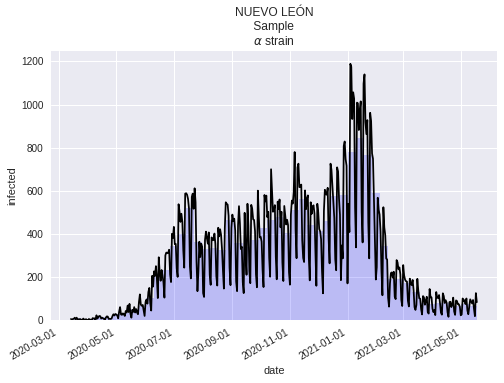

In [8]:
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
from datetime import timedelta

# Date format
date_format = DateFormatter('%Y-%m-%d')

# Sample in date
sample_date_alpha=[]
sample_num_alpha=df_sample_alpha.tiempo.to_numpy()
for i in range(len(sample_num_alpha)):
    sample_date_alpha.append(range_dates_rt[0]+timedelta(days=int(sample_num_alpha[i])))

# Visualization
plt.style.use('seaborn')
f=plt.figure()
plt.plot_date(df_state_for_proof_alpha.Fecha,df_state_for_proof_alpha.CasosDiarios,fmt='k-')
plt.hist(sample_date_alpha,
         orientation='vertical', alpha=0.2, bins=50, color='b')
plt.gcf().autofmt_xdate()
plt.gca().xaxis.set_major_formatter(date_format)
plt.title(f'{state_for_proof}\n Sample \n'+r'$\alpha$ strain')
plt.xlabel('date')
plt.ylabel('infected')

# Color EPS and PNG
f.set_rasterized(True)
f.savefig(ImageDir+'sample_alpha.eps',rasterized=True,dpi=300)
f.savefig(ImageDir+'sample_alpha.png')

# Gray PNG
img = Image.open(ImageDir+'sample_alpha.png').convert('LA')
img.save(ImageDir+'sample_alpha_gray.png')

# Gray EPS
img = Image.open(ImageDir+'sample_alpha.eps')
img.load(scale=4)   
img.convert("L").save(ImageDir+'sample_alpha_gray.eps')
plt.show()

Moreover, we show $R_t$ data 

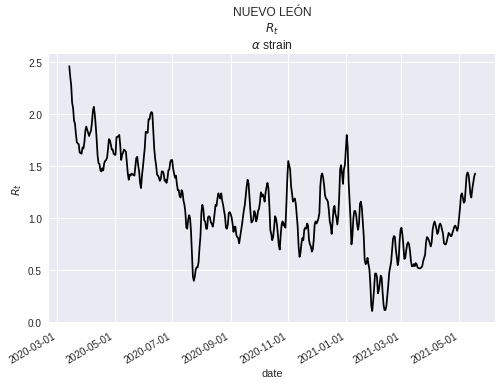

In [9]:
f=plt.figure()
plt.plot_date(df_state_for_proof_alpha.Fecha,df_state_for_proof_alpha.Rt,fmt='k-')
plt.gcf().autofmt_xdate()
plt.gca().xaxis.set_major_formatter(date_format)
plt.title(f'{state_for_proof}\n'+r'$R_t$'+'\n'+r'$\alpha$ strain')
plt.xlabel('date')
plt.ylabel(r'$R_t$')
f.set_rasterized(True)
f.savefig(ImageDir+'rt_alpha.eps',rasterized=True,dpi=300)
plt.show()

### Initial conditions

We get Gompertz-Mixture parameters. First, we obtain initial conditions for EM Algorithm

In [10]:
import initial_conditions
importlib.reload(initial_conditions)
from initial_conditions import estimate_initial_parameters_risk
G = [1, 2, 3, 4]
'''
Initial conditions regression version 1
'''
data_state_alpha = df_state_for_proof_alpha.copy()
data_sample_alpha = df_sample_alpha.copy()
baseline_IC_state_for_proof_alpha= estimate_initial_parameters_risk(
    G, data_sample_alpha, data_state_alpha)
baseline_IC_state_for_proof_alpha

{0: array([-9.73282976, -0.0425848 ]),
 1: array([-12.38344848,  -0.03817699]),
 2: array([-15.44893189,  -0.03846115]),
 3: array([-12.0380966 ,  -0.02214534]),
 'prob_a_priori': array([0.27036521, 0.08820184, 0.31107141, 0.33036154])}

### Estimation

First, we estimate baseline paramters for Gompertz-Mixture model, then we accelerate that model

In [112]:
import opt_baseline
importlib.reload(opt_baseline)
from opt_baseline import mgomp

'''
Preparing Initial Conditions
'''
G = len(baseline_IC_state_for_proof_alpha['prob_a_priori'])
num_parameters = 2
est_in = np.empty((G, num_parameters))
pi_in = baseline_IC_state_for_proof_alpha['prob_a_priori']

for i in range(G):
    est_in[i] = baseline_IC_state_for_proof_alpha[i]


'''
Esimation and Results
'''
NBOOT = 1
MG_baseline_alpha = mgomp(df_sample_alpha, NBOOT, est_in, pi_in, G)
MG_baseline_alpha.getest()
MG_baseline_alpha.output()

Initial parameters: 
[[ -9.73282976  -0.0425848 ]
 [-12.38344848  -0.03817699]
 [-15.44893189  -0.03846115]
 [-12.0380966   -0.02214534]]

Results summarize
Bootstrap= 0, Iter= 144


Component 0: gamma= -11.9803, kappa= -0.0686
Component 1: gamma= -9.0767, kappa= -0.0236
Component 2: gamma= -19.0378, kappa= -0.0504
Component 3: gamma= -10.6424, kappa= -0.0184


Mixture proportion 0: 0.1081
Mixture proportion 1: 0.4132
Mixture proportion 2: 0.3080
Mixture proportion 3: 0.1707


Obtain the coefficients of proportional hazard model

In [130]:
'''
Baseline Hazard and Cum Hazard version 1
'''
data_sample = df_sample_alpha.copy()
data_state = df_state_for_proof_alpha.copy()

days_alpha = data_state_alpha.index.to_numpy()

'''
Hazard
'''
cum_hazard_alpha, hazard_alpha= MG_baseline_alpha.hazard(days_alpha)

'''
Rt coefficients
'''
importlib.reload(initial_conditions)
from initial_conditions import estimate_parameters_Rt_cum_hazard,estimate_parameters_Rt_hazard

'''
Estimation of Rt coeficients
'''
cs_cum_hazard_par_alpha = inter_soft(days_alpha, cum_hazard_alpha, 1)
cs_hazard_par_alpha=inter_soft(days_alpha,hazard_alpha,1)
Rt_coef_hazard_alpha, labels_cum_hazard_alpha, gm_cum_hazard_alpha = estimate_parameters_Rt_hazard(
    [1], data_sample, data_state, cs_hazard_par_alpha
)
print('Los coeficientes del Rt que aceleran el riesgo acumulado son: ')
print(Rt_coef_hazard_alpha)

Los coeficientes del Rt que aceleran el riesgo acumulado son: 
[-0.04735369]


### Display

First, we get the optimal number of susceptible population for the model

Levenberg-Marquardt algorithm CONVERGED
z0 =  10.0
f(z0) =  218068057.0796266
zk =  [37.93487407]
f(zk) =  1740012.2131176507
|pk| =  4.9313904345654254e-11
k =  7


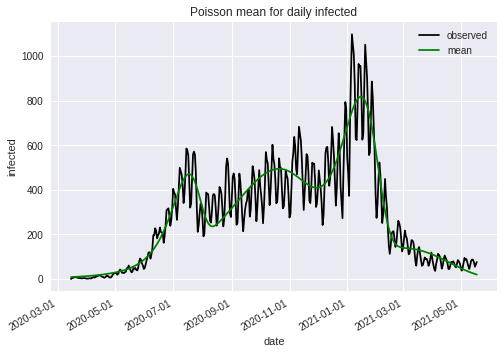

In [131]:
importlib.reload(initial_conditions)
from initial_conditions import *

# Get initial number of susceptibles
num_cum_alpha = G_sample_alpha.num_cum_mean
a_alpha=cum_hazard_alpha[1:]-cum_hazard_alpha[:-1]
a_alpha=np.concatenate(([0.0],a_alpha))
b_alpha=np.array([np.prod(1.0-a_alpha[:i+1]) for i in range(len(a_alpha))])
#b_alpha=np.concatenate(([1.0],b_alpha))

# Data for optimization
x_alpha=b_alpha[1:]-b_alpha[:-1]
y_alpha=num_cum_alpha[1:]-num_cum_alpha[:-1]
date_alpha=df_state_for_proof_alpha.Fecha.to_list()[1:]
Y0_alpha=num_cum_alpha[0]
P_alpha=pob
k0=10.0

# Optimization
N=5000
tol=np.finfo(float).eps**(1/2)
paramf_alpha=np.array([x_alpha,y_alpha]).T
mu_ref=0.1
f=plt.figure()
dic_results_asym_alpha=proof_levenberg_marquardt_nlls(R,J,k0,N,tol,mu_ref,paramf_alpha,P_alpha,Y0_alpha,date_alpha)

# Color EPS and PNG
f.set_rasterized(True)
f.savefig(ImageDir+'LM_alpha.eps',rasterized=True,dpi=300)
f.savefig(ImageDir+'LM_alpha.png')

# Gray PNG
img = Image.open(ImageDir+'LM_alpha.png').convert('LA')
img.save(ImageDir+'LM_alpha_gray.png')

# Gray EPS
img = Image.open(ImageDir+'LM_alpha.eps')
img.load(scale=4)   
img.convert("L").save(ImageDir+'LM_alpha_gray.eps')
plt.show()

Posteriormente realizamos la visualización del ajuste obtenido

In [132]:
from scipy.stats import poisson
'''
Poisson process baseline model
'''
k_alpha=np.squeeze(dic_results_asym_alpha['zk'])
# Poisson process
X_baseline_alpha = np.empty(len(days_alpha))
A_baseline_alpha = np.empty(len(days_alpha))
X_baseline_alpha[0] = num_cum_alpha[0]
A_baseline_alpha[0] = X_baseline_alpha[0]
for i in range(1, len(X_baseline_alpha)):
    if i <= len(num_cum_alpha)-1:
        mu_est = (P_alpha/k_alpha-A_baseline_alpha[i-1]) * \
            (cum_hazard_alpha[i]-cum_hazard_alpha[i-1])
    else:
        mu_est = (num_cum_alpha[0])*(cum_hazard_alpha[i]-cum_hazard_alpha[i-1])
    X_baseline_alpha[i] = poisson.rvs(mu=mu_est)
    A_baseline_alpha[i] = A_baseline_alpha[i-1]+X_baseline_alpha[i]


Analogously, we estimate asymptote for accelerated process

Levenberg-Marquardt algorithm CONVERGED
z0 =  2.0
f(z0) =  9014261578.981558
zk =  [38.03523267]
f(zk) =  1699511.2410082563
|pk| =  4.484589809413841e-11
k =  10


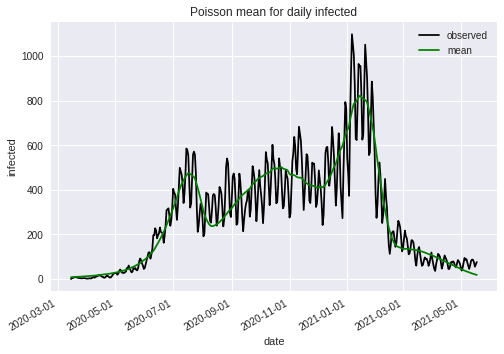

In [133]:
# Corresponding Rt
rt_acc_alpha = df_state_for_proof_alpha.Rt.to_numpy()
rt_acc_alpha = rt_acc_alpha-np.mean(rt_acc_alpha)

# Accelerated cumulative risk
cum_hazard_alpha_acc, hazard_alpha_acc=MG_baseline_alpha.hazard_acc(days_alpha,rt_acc_alpha,Rt_coef_hazard_alpha[0])
a_alpha_acc=cum_hazard_alpha_acc[1:]-cum_hazard_alpha_acc[:-1]
a_alpha_acc=np.concatenate(([0.0],a_alpha_acc))
b_alpha_acc=np.array([np.prod(1.0-a_alpha_acc[:i+1]) for i in range(len(a_alpha_acc))])
#b_alpha_acc=np.concatenate(([1.0],b_alpha_acc))

# Data for optimization
x_alpha_acc=b_alpha_acc[1:]-b_alpha_acc[:-1]
y_alpha_acc=num_cum_alpha[1:]-num_cum_alpha[:-1]
date_alpha=df_state_for_proof_alpha.Fecha.to_list()[1:]
Y0_alpha=num_cum_alpha[0]
P_alpha=pob
k0=2.0

# Optimization
N=5000
tol=np.finfo(float).eps**(1/2)
paramf_alpha=np.array([x_alpha_acc,y_alpha_acc]).T
mu_ref=0.1
f=plt.figure()
dic_results_asym_alpha_acc=proof_levenberg_marquardt_nlls(R,J,k0,N,tol,mu_ref,paramf_alpha,P_alpha,Y0_alpha,date_alpha)

# Color EPS and PNG
f.set_rasterized(True)
f.savefig(ImageDir+'LM_alpha_acc.eps',rasterized=True,dpi=300)
f.savefig(ImageDir+'LM_alpha_acc.png')

# Gray PNG
img = Image.open(ImageDir+'LM_alpha_acc.png').convert('LA')
img.save(ImageDir+'LM_alpha_acc_gray.png')

# Gray EPS
img = Image.open(ImageDir+'LM_alpha_acc.eps')
img.load(scale=4)   
img.convert("L").save(ImageDir+'LM_alpha_acc_gray.eps')
plt.show()

Finally, we obtain the accelerated process

In [167]:
'''
Poisson process accelerated model
'''
k_alpha_acc=np.squeeze(dic_results_asym_alpha_acc['zk'])
# Poisson process
X_acc_cum_hazard_alpha = np.empty(len(days_alpha))
A_acc_cum_hazard_alpha = np.empty(len(days_alpha))

X_acc_cum_hazard_alpha[0] = num_cum_alpha[0]
A_acc_cum_hazard_alpha[0] = X_acc_cum_hazard_alpha[0]
for i in range(1, len(X_acc_cum_hazard_alpha)):
    if i <= len(num_cum_alpha)-1:
        mu_est =  (P_alpha/k_alpha_acc-A_acc_cum_hazard_alpha[i-1])*(cum_hazard_alpha_acc[i]-cum_hazard_alpha_acc[i-1])
    else:
        mu_est =(A_acc_cum_hazard_alpha[i-len(num_cum_alpha)])*(cum_hazard_alpha_acc[i]-cum_hazard_alpha_acc[i-1])
    X_acc_cum_hazard_alpha[i] = poisson.rvs(mu=mu_est)
    A_acc_cum_hazard_alpha[i] = A_acc_cum_hazard_alpha[i-1]+X_acc_cum_hazard_alpha[i]

Throughout simulation we obtain the growth curve and density for $\alpha$ process

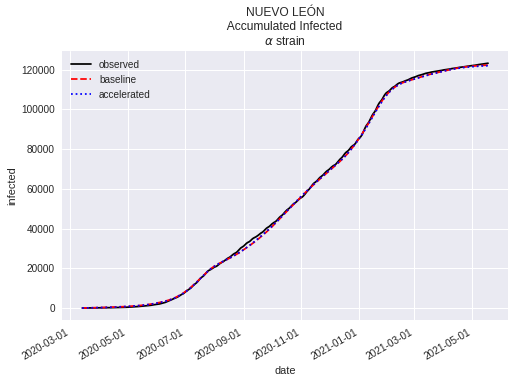

In [168]:
'''
Growth model alpha process
'''

date_state_alpha = df_state_for_proof_alpha.Fecha.to_list()

f=plt.figure()
plt.plot_date(date_state_alpha, num_cum_alpha, fmt='-k', label='observed')
plt.plot_date(date_state_alpha, A_baseline_alpha, fmt='--r',label='baseline')
plt.plot_date(date_state_alpha, A_acc_cum_hazard_alpha, fmt=':b', label='accelerated')

plt.gcf().autofmt_xdate()
plt.gca().xaxis.set_major_formatter(date_format)
plt.legend()
plt.title(f'{state_for_proof}\n Accumulated Infected \n'+ r'$\alpha$ strain')
plt.xlabel('date')
plt.ylabel('infected')
f.set_rasterized(True)
f.savefig(ImageDir+'accumulated_alpha.eps',rasterized=True,dpi=300)
f.savefig(ImageDir+'accumulated_alpha.png',rasterized=True,dpi=300)
img = Image.open(ImageDir+'accumulated_alpha.png').convert('LA')
img.save(ImageDir+'accumulated_alpha_gray.png')
img = Image.open(ImageDir+'accumulated_alpha.eps')
img.convert("L").save(ImageDir+'accumulated_alpha_gray.eps')

# Color EPS and PNG
f.set_rasterized(True)
f.savefig(ImageDir+'accumulated_alpha.eps',rasterized=True,dpi=300)
f.savefig(ImageDir+'accumulated_alpha.png')

# Gray PNG
img = Image.open(ImageDir+'accumulated_alpha.png').convert('LA')
img.save(ImageDir+'accumulated_alpha_gray.png')

# Gray EPS
img = Image.open(ImageDir+'accumulated_alpha.eps')
img.load(scale=4)   
img.convert("L").save(ImageDir+'accumulated_alpha_gray.eps')
plt.show()

The density is

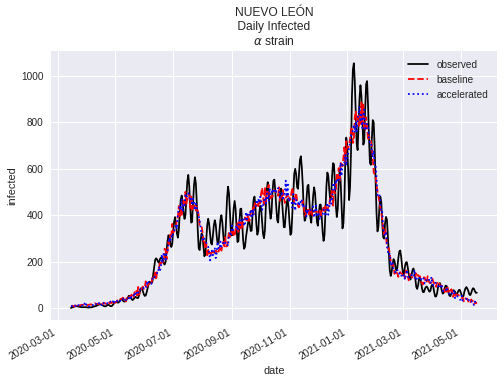

In [169]:
'''
Density alpha process
'''
from opt_baseline import mobile_mean
'''
Interpolation
'''
SOFT_PAR = 1
cs_density_baseline = inter_soft(
    days_alpha[1:], A_baseline_alpha[1:]-A_baseline_alpha[:-1], SOFT_PAR)
cs_density_acc = inter_soft(
    days_alpha[1:], A_acc_cum_hazard_alpha[1:]-A_acc_cum_hazard_alpha[:-1], SOFT_PAR)
cs_density_obs = mobile_mean(
    days_alpha[1:], num_cum_alpha[1:]-num_cum_alpha[:-1], M_MEAN)

'''
Plotting
'''
f=plt.figure()
plt.plot_date(date_state_alpha[1:], cs_density_obs(
    days_alpha[1:]), fmt='k-', label='observed')
plt.plot_date(date_state_alpha[1:], cs_density_baseline(
    days_alpha[1:]), fmt='r--', label='baseline')
plt.plot_date(date_state_alpha[1:], cs_density_acc(days_alpha[1:]), fmt='b:', label='accelerated')
plt.gcf().autofmt_xdate()
plt.gca().xaxis.set_major_formatter(date_format)
plt.legend()
plt.title(f'{state_for_proof}\n Daily Infected \n'+ r'$\alpha$ strain')
plt.xlabel('date')
plt.ylabel('infected')

# Color EPS and PNG
f.set_rasterized(True)
f.savefig(ImageDir+'density_alpha.eps',rasterized=True,dpi=300)
f.savefig(ImageDir+'density_alpha.png')

# Gray PNG
img = Image.open(ImageDir+'density_alpha.png').convert('LA')
img.save(ImageDir+'density_alpha_gray.png')

# Gray EPS
img = Image.open(ImageDir+'density_alpha.eps')
img.load(scale=4)   
img.convert("L").save(ImageDir+'density_alpha_gray.eps')
plt.show()

We use mean poisson deviance in order to measure the error

In [170]:
from sklearn.metrics import mean_poisson_deviance

deviance_error_baseline_alpha=mean_poisson_deviance(G_sample_alpha.num_dia_mean,X_baseline_alpha)
deviance_error_acc_cum_hazard_alpha=mean_poisson_deviance(G_sample_alpha.num_dia_mean,X_acc_cum_hazard_alpha)
print('deviance alpha baseline : %.4f' %(deviance_error_baseline_alpha))
print('deviance alpha accelerated: %.4f' %(deviance_error_acc_cum_hazard_alpha))

deviance alpha baseline : 23.4790
deviance alpha accelerated: 22.9793


## $\Delta$ process 

We get $\Delta$ database

In [144]:
# delta data base
df_state_for_proof_delta=df_state_for_proof[(df_state_for_proof.Fecha>range_cepas_dates[1]) & (df_state_for_proof.Fecha<=range_cepas_dates[2])]
df_state_for_proof_delta['Rt']=cs_rt(df_state_for_proof_delta.index.to_numpy())

# scale variables
'''
Accumulated data for delta strain
'''
last_num_cum_alpha=df_state_for_proof_alpha.CasosAcumulados.to_list()[-1]
df_state_for_proof_delta.CasosAcumulados=df_state_for_proof_delta.CasosAcumulados.to_numpy()-last_num_cum_alpha

'''
Restart time
'''
df_state_for_proof_delta.index=df_state_for_proof_delta.index.to_numpy()-num_delta_rt_begin
df_state_for_proof_delta.head()

,Fecha,CasosAcumulados,CasosDiarios,Rt
1.0,2021-05-19,91.0,91.0,4.13
2.0,2021-05-20,187.0,96.0,3.32
3.0,2021-05-21,314.0,127.0,3.36
4.0,2021-05-22,344.0,30.0,2.81
5.0,2021-05-23,370.0,26.0,2.51


### Sampling

We get the sample from `CasosAcumulados/CasosDiarios` data.

In [145]:
import samples
importlib.reload(samples)
SAMPLES = 20
M_MEAN = 3
from samples import g_sample
SamplesDir = DataDir+'Samples/'
'''
delta sample
'''
G_sample_delta=g_sample(df_state_for_proof_delta,SamplesDir+state_for_proof+'_delta.csv',SAMPLES,M_MEAN)
G_sample_delta.main()
df_sample_delta=G_sample_delta.get_sampling_data()
df_sample_delta['Rt']=cs_rt(df_sample_delta.tiempo.to_numpy()+num_delta_rt_begin)

Posteriormente, visualizamos que tan útil es este muestro con los datos observados de `CasosDiarios`

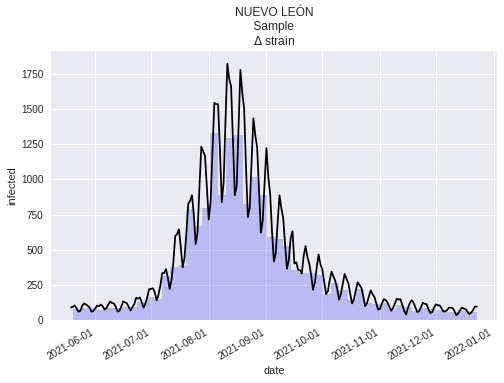

In [146]:
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
from datetime import timedelta

# Date format
date_format = DateFormatter('%Y-%m-%d')

# Sample in date
sample_date_delta=[]
sample_num_delta=df_sample_delta.tiempo.to_numpy()
for i in range(len(sample_num_delta)):
    sample_date_delta.append(range_cepas_dates[1]+timedelta(days=int(sample_num_delta[i])))

# Visualization
plt.style.use('seaborn')
f=plt.figure()
plt.plot_date(df_state_for_proof_delta.Fecha,G_sample_delta.num_dia_mean,fmt='k-')
plt.hist(sample_date_delta,
         orientation='vertical', alpha=0.2, bins=50, color='b')
plt.gcf().autofmt_xdate()
plt.gca().xaxis.set_major_formatter(date_format)
plt.title(f'{state_for_proof}\n Sample \n'+r'$\Delta$ strain')
plt.xlabel('date')
plt.ylabel('infected')
# Color EPS and PNG
f.set_rasterized(True)
f.savefig(ImageDir+'sample_delta.eps',rasterized=True,dpi=300)
f.savefig(ImageDir+'sample_delta.png')

# Gray PNG
img = Image.open(ImageDir+'sample_delta.png').convert('LA')
img.save(ImageDir+'sample_delta_gray.png')

# Gray EPS
img = Image.open(ImageDir+'sample_delta.eps')
img.load(scale=4)   
img.convert("L").save(ImageDir+'sample_delta_gray.eps')
plt.show()

Visualizamos el $R_t$ para esta cepa correspondiente al dominio temporal de la cepa $\delta$

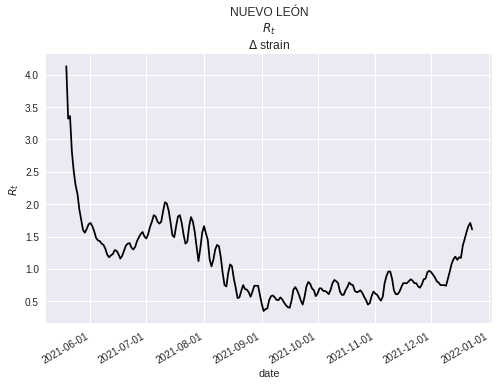

In [147]:
f=plt.figure()
plt.plot_date(df_state_for_proof_delta.Fecha,df_state_for_proof_delta.Rt,fmt='k-')
plt.gcf().autofmt_xdate()
plt.gca().xaxis.set_major_formatter(date_format)
plt.title(f'{state_for_proof}\n'+r'$R_t$'+'\n'+r'$\Delta$ strain')
plt.xlabel('date')
plt.ylabel(r'$R_t$')
f.set_rasterized(True)
f.savefig(ImageDir+'rt_delta.eps',rasterized=True,dpi=300)
plt.show()

### Initial conditions

We get initial condition for iterative estimation using the last sample

In [148]:
import initial_conditions
importlib.reload(initial_conditions)
from initial_conditions import estimate_initial_parameters_risk
G = [1, 2, 3, 4]
'''
Initial conditions regression version 1
'''
data_state_delta = df_state_for_proof_delta.copy()
data_sample_delta = df_sample_delta.copy()
baseline_IC_state_for_proof_delta= estimate_initial_parameters_risk(
    G, data_sample_delta, data_state_delta)
baseline_IC_state_for_proof_delta

{0: array([-6.39281103, -0.07927761]),
 1: array([-8.33064718, -0.06098722]),
 2: array([-9.53857751, -0.04850934]),
 3: array([-11.50087029,  -0.04483675]),
 'prob_a_priori': array([0.52862971, 0.06312013, 0.23199249, 0.17625767])}

### Estimation
We estimate Gompertz-Mixture parameters for $\Delta$ process

In [149]:
import opt_baseline
importlib.reload(opt_baseline)
from opt_baseline import mgomp

'''
Preparing Initial Conditions
'''
G = len(baseline_IC_state_for_proof_delta['prob_a_priori'])
num_parameters = 2
est_in = np.empty((G, num_parameters))
pi_in = baseline_IC_state_for_proof_delta['prob_a_priori']

for i in range(G):
    est_in[i] = baseline_IC_state_for_proof_delta[i]

'''
Esimation and Results
'''
NBOOT = 1
MG_baseline_delta = mgomp(df_sample_delta, NBOOT, est_in, pi_in, G)
MG_baseline_delta.getest()
MG_baseline_delta.output()

Initial parameters: 
[[ -6.39281103  -0.07927761]
 [ -8.33064718  -0.06098722]
 [ -9.53857751  -0.04850934]
 [-11.50087029  -0.04483675]]

Results summarize
Bootstrap= 0, Iter= 351


Component 0: gamma= -10.1125, kappa= -0.0939
Component 1: gamma= -9.6000, kappa= -0.0703
Component 2: gamma= -6.6001, kappa= -0.0247
Component 3: gamma= -16.3780, kappa= -0.0685


Mixture proportion 0: 0.2388
Mixture proportion 1: 0.2905
Mixture proportion 2: 0.4275
Mixture proportion 3: 0.0431


Afterwards, we accelerate baseline model

In [171]:
'''
Baseline Hazard and Cum Hazard version 1
'''
data_sample = df_sample_delta.copy()
data_state = df_state_for_proof_delta.copy()

days_delta = data_state_delta.index.to_numpy()
cum_hazard_delta, hazard_delta= MG_baseline_delta.hazard(days_delta)

'''
Rt coefficients
'''
importlib.reload(initial_conditions)
from initial_conditions import estimate_parameters_Rt_cum_hazard,estimate_parameters_Rt_hazard

'''
Estimation of Rt coeficients
'''
cs_cum_hazard_par_delta = inter_soft(days_delta, cum_hazard_delta, 1)
cs_hazard_par_delta=inter_soft(days_delta,hazard_delta,1)
Rt_coef_hazard_delta, labels_cum_hazard_delta, gm_cum_hazard_delta = estimate_parameters_Rt_hazard(
    [1], data_sample, data_state, cs_hazard_par_delta
)
print('Los coeficientes del Rt que aceleran el riesgo acumulado son: ')
print(Rt_coef_hazard_delta)

Los coeficientes del Rt que aceleran el riesgo acumulado son: 
[-0.01372716]


### Display

We consider a certain susceptible population due to vaccination and data nature. Analogously, we obtain the carrying capacity of this process.


Levenberg-Marquardt algorithm CONVERGED
z0 =  10.0
f(z0) =  109780882.36219126
zk =  [27.54847177]
f(zk) =  2152398.1661278456
|pk| =  5.378797844136732e-10
k =  6


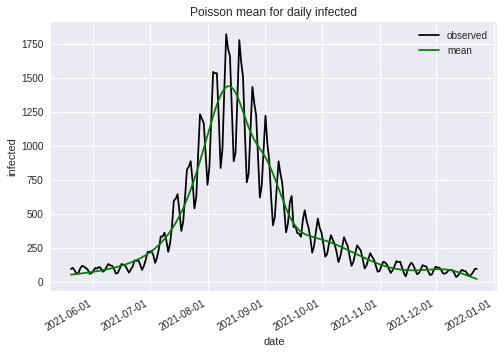

In [172]:
importlib.reload(initial_conditions)
from initial_conditions import *

# Get initial number of susceptibles
num_cum_delta = G_sample_delta.num_cum_mean
a_delta=cum_hazard_delta[1:]-cum_hazard_delta[:-1]
a_delta=np.concatenate(([0.0],a_delta))
b_delta=np.array([np.prod(1.0-a_delta[:i+1]) for i in range(len(a_delta))])
#b_delta=np.concatenate(([1.0],b_delta))

# Data for optimization
x_delta=b_delta[1:]-b_delta[:-1]
y_delta=num_cum_delta[1:]-num_cum_delta[:-1]
date_delta=df_state_for_proof_delta.Fecha.to_list()[1:]
Y0_delta=num_cum_delta[0]
P_delta=0.51*pob
k0=10.0

# Optimization
N=5000
tol=np.finfo(float).eps**(1/2)
paramf_delta=np.array([x_delta,y_delta]).T
mu_ref=0.1
f=plt.figure()
dic_results_asym_delta=proof_levenberg_marquardt_nlls(R,J,k0,N,tol,mu_ref,paramf_delta,P_delta,Y0_delta,date_delta)
# Color EPS and PNG
f.set_rasterized(True)
f.savefig(ImageDir+'LM_delta.eps',rasterized=True,dpi=300)
f.savefig(ImageDir+'LM_delta.png')

# Gray PNG
img = Image.open(ImageDir+'LM_delta.png').convert('LA')
img.save(ImageDir+'LM_delta_gray.png')

# Gray EPS
img = Image.open(ImageDir+'LM_delta.eps')
img.load(scale=4)   
img.convert("L").save(ImageDir+'LM_delta_gray.eps')
plt.show()

After that we obtain baseline and accelerated process with random simulation

In [173]:
from scipy.stats import poisson
'''
Poisson process baseline model
'''
k_delta=np.squeeze(dic_results_asym_delta['zk'])
# Poisson process
X_baseline_delta = np.empty(len(days_delta))
A_baseline_delta = np.empty(len(days_delta))
X_baseline_delta[0] = num_cum_delta[0]
A_baseline_delta[0] = X_baseline_delta[0]
for i in range(1, len(X_baseline_delta)):
    if i <= len(num_cum_delta)-1:
        mu_est = (P_delta/k_delta-A_baseline_delta[i-1]) * \
            (cum_hazard_delta[i]-cum_hazard_delta[i-1])
    else:
        mu_est = (num_cum_delta[0])*(cum_hazard_delta[i]-cum_hazard_delta[i-1])
    X_baseline_delta[i] = poisson.rvs(mu=mu_est)
    A_baseline_delta[i] = A_baseline_delta[i-1]+X_baseline_delta[i]

Estimate asymptote

Levenberg-Marquardt algorithm CONVERGED
z0 =  2.0
f(z0) =  5731920983.446106
zk =  [27.60285155]
f(zk) =  2138662.868440556
|pk| =  1.0526504918364172e-10
k =  9


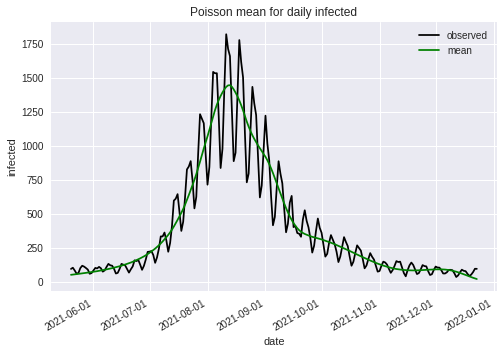

In [182]:
# Corresponding Rt
rt_acc_delta = df_state_for_proof_delta.Rt.to_numpy()
rt_acc_delta = rt_acc_delta-np.mean(rt_acc_delta)

# Accelerated cumulative risk
cum_hazard_delta_acc, hazard_delta_acc=MG_baseline_delta.hazard_acc(days_delta,rt_acc_delta,Rt_coef_hazard_delta[0])
a_delta_acc=cum_hazard_delta_acc[1:]-cum_hazard_delta_acc[:-1]
a_delta_acc=np.concatenate(([0.0],a_delta_acc))
b_delta_acc=np.array([np.prod(1.0-a_delta_acc[:i+1]) for i in range(len(a_delta_acc))])
#b_delta_acc=np.concatenate(([1.0],b_delta_acc))

# Data for optimization
x_delta_acc=b_delta_acc[1:]-b_delta_acc[:-1]
y_delta_acc=num_cum_delta[1:]-num_cum_delta[:-1]
date_delta=df_state_for_proof_delta.Fecha.to_list()[1:]
Y0_delta=num_cum_delta[0]
P_delta=pob*0.51
k0=2.0

# Optimization
N=5000
tol=np.finfo(float).eps**(1/2)
paramf_delta=np.array([x_delta_acc,y_delta_acc]).T
mu_ref=0.1
f=plt.figure()
dic_results_asym_delta_acc=proof_levenberg_marquardt_nlls(R,J,k0,N,tol,mu_ref,paramf_delta,P_delta,Y0_delta,date_delta)

# Color EPS and PNG
f.set_rasterized(True)
f.savefig(ImageDir+'LM_delta_acc.eps',rasterized=True,dpi=300)
f.savefig(ImageDir+'LM_delta_acc.png')

# Gray PNG
img = Image.open(ImageDir+'LM_delta_acc.png').convert('LA')
img.save(ImageDir+'LM_delta_acc_gray.png')

# Gray EPS
img = Image.open(ImageDir+'LM_delta_acc.eps')
img.load(scale=4)   
img.convert("L").save(ImageDir+'LM_delta_acc_gray.eps')
plt.show()

Asymptote for accelerated delta process

In [183]:
'''
Poisson process accelerated model
'''
k_delta_acc=np.squeeze(dic_results_asym_delta_acc['zk'])
# Poisson process
X_acc_cum_hazard_delta = np.empty(len(days_delta))
A_acc_cum_hazard_delta = np.empty(len(days_delta))

X_acc_cum_hazard_delta[0] = num_cum_delta[0]
A_acc_cum_hazard_delta[0] = X_acc_cum_hazard_delta[0]
for i in range(1, len(X_acc_cum_hazard_delta)):
    if i <= len(num_cum_delta)-1:
        mu_est =  (P_delta/k_delta_acc-A_acc_cum_hazard_delta[i-1])*(cum_hazard_delta_acc[i]-cum_hazard_delta_acc[i-1])
    else:
        mu_est =(A_acc_cum_hazard_delta[i-len(num_cum_delta)])*(cum_hazard_delta_acc[i]-cum_hazard_delta_acc[i-1])
    X_acc_cum_hazard_delta[i] = poisson.rvs(mu=mu_est)
    A_acc_cum_hazard_delta[i] = A_acc_cum_hazard_delta[i-1]+X_acc_cum_hazard_delta[i]

The growth curve is

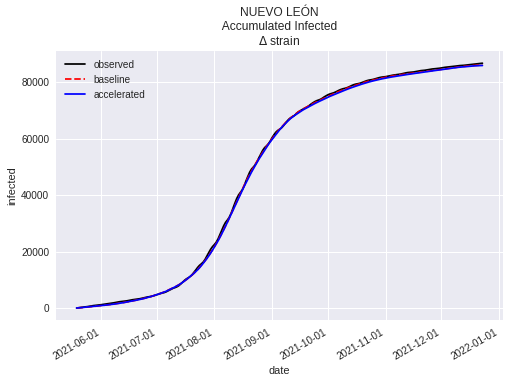

In [176]:
'''
Growth model delta process
'''

date_state_delta = df_state_for_proof_delta.Fecha.to_list()

f=plt.figure()
plt.plot_date(date_state_delta, num_cum_delta, fmt='-', color='k', label='observed')
plt.plot_date(date_state_delta, A_baseline_delta, fmt='--', color='r', label='baseline')
plt.plot_date(date_state_delta, A_acc_cum_hazard_delta, fmt=':',color='b', label='accelerated', linestyle='-')

plt.gcf().autofmt_xdate()
plt.gca().xaxis.set_major_formatter(date_format)
plt.legend()
plt.xlabel('date')
plt.ylabel('infected')
plt.title(f'{state_for_proof}\n Accumulated Infected \n'+ r'$\Delta$ strain')
# Color EPS and PNG
f.set_rasterized(True)
f.savefig(ImageDir+'accumulated_delta.eps',rasterized=True,dpi=300)
f.savefig(ImageDir+'accumulated_delta.png')

# Gray PNG
img = Image.open(ImageDir+'accumulated_delta.png').convert('LA')
img.save(ImageDir+'accumulated_delta_gray.png')

# Gray EPS
img = Image.open(ImageDir+'accumulated_delta.eps')
img.load(scale=4)   
img.convert("L").save(ImageDir+'accumulated_delta_gray.eps')
plt.show()

And the daily infected curve is

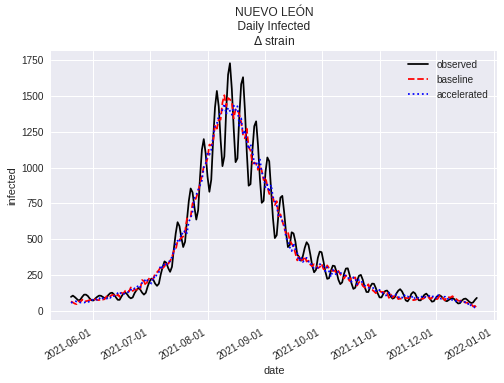

In [177]:
'''
Density delta process
'''
from opt_baseline import mobile_mean
'''
Interpolation
'''
SOFT_PAR = 1
cs_density_baseline = inter_soft(
    days_delta[1:], A_baseline_delta[1:]-A_baseline_delta[:-1], SOFT_PAR)
cs_density_acc = inter_soft(
    days_delta[1:], A_acc_cum_hazard_delta[1:]-A_acc_cum_hazard_delta[:-1], SOFT_PAR)
cs_density_obs = mobile_mean(
    days_delta[1:], num_cum_delta[1:]-num_cum_delta[:-1], M_MEAN)

'''
Plotting
'''
f=plt.figure()
plt.plot_date(date_state_delta[1:], cs_density_obs(
    days_delta[1:]), fmt='k-', label='observed')
plt.plot_date(date_state_delta[1:], cs_density_baseline(
    days_delta[1:]), fmt='r--', label='baseline')
plt.plot_date(date_state_delta[1:], cs_density_acc(days_delta[1:]), fmt='b:', label='accelerated')
plt.gcf().autofmt_xdate()
plt.gca().xaxis.set_major_formatter(date_format)
plt.legend()
plt.title(f'{state_for_proof}\n Daily Infected \n'+ r'$\Delta$ strain')
plt.xlabel('date')
plt.ylabel('infected')
# Color EPS and PNG
f.set_rasterized(True)
f.savefig(ImageDir+'density_delta.eps',rasterized=True,dpi=300)
f.savefig(ImageDir+'density_delta.png')

# Gray PNG
img = Image.open(ImageDir+'density_delta.png').convert('LA')
img.save(ImageDir+'density_delta_gray.png')

# Gray EPS
img = Image.open(ImageDir+'density_delta.eps')
img.load(scale=4)   
img.convert("L").save(ImageDir+'density_delta_gray.eps')
plt.show()

Finally, we get deviance for each model

In [178]:
from sklearn.metrics import mean_poisson_deviance

deviance_error_baseline_delta=mean_poisson_deviance(G_sample_delta.num_dia_mean,X_baseline_delta)
deviance_error_acc_cum_hazard_delta=mean_poisson_deviance(G_sample_delta.num_dia_mean,X_acc_cum_hazard_delta)
print('deviance delta baseline : %.4f' %(deviance_error_baseline_delta))
print('deviance delta acelerated : %.4f' %(deviance_error_acc_cum_hazard_delta))

deviance delta baseline : 28.5896
deviance delta acelerated : 30.4385


## $\Omicron$ process

Finally, we do the same with $\Omicron$ data

In [30]:
# omicron database
df_state_for_proof_omicron=df_state_for_proof[df_state_for_proof.Fecha>range_cepas_dates[2]]

# scale variables
'''
Accumulated data for omicron strain
'''
last_num_cum_delta=df_state_for_proof_delta.CasosAcumulados.to_list()[-1]
df_state_for_proof_omicron.CasosAcumulados=df_state_for_proof_omicron.CasosAcumulados.to_numpy()-last_num_cum_delta-last_num_cum_alpha

'''
Restart time
'''
df_state_for_proof_omicron.index=df_state_for_proof_omicron.index.to_numpy()-num_omicron_rt_begin
df_state_for_proof_omicron.head()

,Fecha,CasosAcumulados,CasosDiarios
1.0,2021-12-24,108.0,108.0
2.0,2021-12-25,150.0,42.0
3.0,2021-12-26,218.0,68.0
4.0,2021-12-27,545.0,327.0
5.0,2021-12-28,987.0,442.0


### Sampling

Get sample from `CasosAcumulados/CasosDiarios` data

In [31]:
import samples
importlib.reload(samples)
SAMPLES = 30
M_MEAN = 3
from samples import g_sample
SamplesDir = DataDir+'Samples/'
'''
Muestra cepa 
'''
G_sample_omicron=g_sample(df_state_for_proof_omicron,SamplesDir+state_for_proof+'_omicron.csv',SAMPLES,M_MEAN)
G_sample_omicron.main()
df_sample_omicron=G_sample_omicron.get_sampling_data()

We check the last sampling

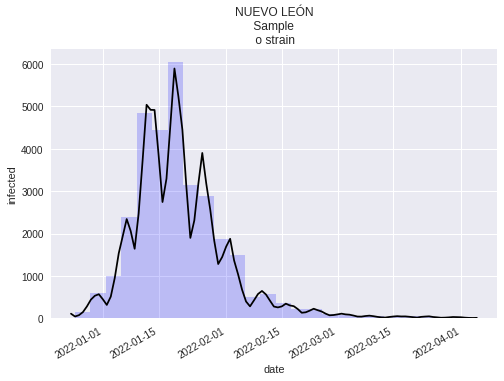

In [32]:
import matplotlib.pyplot as plt
import datetime as dt
from matplotlib.dates import DateFormatter
from datetime import timedelta

# Date format
date_format = DateFormatter('%Y-%m-%d')

# Sample in date
sample_date_omicron=[]
sample_num_omicron=df_sample_omicron.tiempo.to_numpy()
for i in range(len(sample_num_omicron)):
    sample_date_omicron.append(range_cepas_dates[2]+timedelta(days=int(sample_num_omicron[i])))

# Date for truncation
umbral_date=dt.datetime(2022,2,1)

# Visualization
plt.style.use('seaborn')
f=plt.figure()
plt.plot_date(df_state_for_proof_omicron.Fecha,G_sample_omicron.num_dia_mean,fmt='k-')
plt.hist(sample_date_omicron,
         orientation='vertical', alpha=0.2, bins=26, color='b')
plt.gcf().autofmt_xdate()
plt.gca().xaxis.set_major_formatter(date_format)
plt.title(f'{state_for_proof}\n Sample \n o strain')
plt.xlabel('date')
plt.ylabel('infected')
# Color EPS and PNG
f.set_rasterized(True)
f.savefig(ImageDir+'sample_omicron.eps',rasterized=True,dpi=300)
f.savefig(ImageDir+'sample_omicron.png')

# Gray PNG
img = Image.open(ImageDir+'sample_omicron.png').convert('LA')
img.save(ImageDir+'sample_omicron_gray.png')

# Gray EPS
img = Image.open(ImageDir+'sample_omicron.eps')
img.load(scale=4)   
img.convert("L").save(ImageDir+'sample_omicron_gray.eps')
plt.show()

How we use this strain as example of truncated data we show the plot with a vertical line representing the truncation that we are going to treat later.

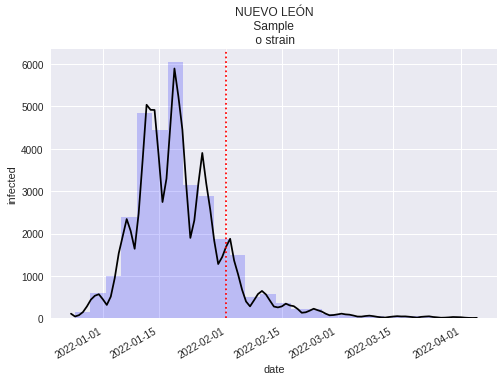

In [33]:
# Visualization
plt.style.use('seaborn')
f=plt.figure()
plt.plot_date(df_state_for_proof_omicron.Fecha,G_sample_omicron.num_dia_mean,fmt='k-')
plt.hist(sample_date_omicron,
         orientation='vertical', alpha=0.2, bins=26, color='b')
plt.axvline(umbral_date,linestyle='dotted',color='r')
plt.gcf().autofmt_xdate()
plt.gca().xaxis.set_major_formatter(date_format)
plt.title(f'{state_for_proof}\n Sample \n o strain')
plt.xlabel('date')
plt.ylabel('infected')
f.set_rasterized(True)
f.savefig(ImageDir+'sample_omicron_with_trun.eps',rasterized=True,dpi=300)
plt.show()

We convert `umbral_date` into numerical value

In [34]:
num_umbral_date = np.squeeze(convert_dates_to_days(
    pd.Series(umbral_date), range_dates_rt[0]))

### Initial conditions

We are going to get Gompertz-Mixture parameters for $\Omicron$ strain. Firts, we determine initial conditions

In [35]:
import initial_conditions
importlib.reload(initial_conditions)
from initial_conditions import estimate_initial_parameters_risk
G = [1, 2, 3, 4]
'''
Initial conditions regression version 1
'''
data_state_omicron = df_state_for_proof_omicron.copy()
data_sample_omicron = df_sample_omicron.copy()
baseline_IC_state_for_proof_omicron= estimate_initial_parameters_risk(
    G, data_sample_omicron, data_state_omicron)
baseline_IC_state_for_proof_omicron

{0: array([-6.82448105, -0.21068634]),
 1: array([-4.25300798, -0.07187016]),
 2: array([-3.43099782, -0.0140591 ]),
 'prob_a_priori': array([0.65510018, 0.26897363, 0.07592619])}

### Estimation

We run EM Algorithm in order to get Gompertz-Mixture parameters for this process

In [36]:
import opt_baseline_trun
importlib.reload(opt_baseline_trun)
from opt_baseline_trun import mgomp

'''
Preparing Initial Conditions
'''
G = len(baseline_IC_state_for_proof_omicron['prob_a_priori'])
num_parameters = 2
est_in = np.empty((G, num_parameters))
pi_in = baseline_IC_state_for_proof_omicron['prob_a_priori']

for i in range(G):
    est_in[i] = baseline_IC_state_for_proof_omicron[i]
    est_in[i][1] =-1.0*est_in[i][1]

'''
Esimation and Results
'''
NBOOT = 1
MG_baseline_omicron = mgomp(df_sample_omicron, NBOOT, est_in, pi_in,G,103.0)
MG_baseline_omicron.getest()
MG_baseline_omicron.output()

Initial parameters: 
[[-6.82448105  0.21068634]
 [-4.25300798  0.07187016]
 [-3.43099782  0.0140591 ]]

Results summarize
Bootstrap= 0, Iter= 60


Component 0: gamma= -6.7695, kappa= 0.2167
Component 1: gamma= -7.0822, kappa= 0.1506
Component 2: gamma= -4.9904, kappa= 0.0378


Mixture proportion 0: 0.4388
Mixture proportion 1: 0.4105
Mixture proportion 2: 0.1507


We get hazard and cumulative hazard for $\Omicron$ process

In [37]:
'''
Baseline Hazard and Cum Hazard version 1
'''
data_sample = df_sample_omicron.copy()
data_state = df_state_for_proof_omicron.copy()

days_omicron = data_state_omicron.index.to_numpy()
cum_hazard_omicron, hazard_omicron= MG_baseline_omicron.hazard(days_omicron)

### Display

As before, we get susceptible population for this process with Levenberg-Marquardt algorithm

Levenberg-Marquardt algorithm CONVERGED
z0 =  10.0
f(z0) =  1976050593.619973
zk =  [45.76349531]
f(zk) =  12186993.064959755
|pk| =  2.9774094592923135e-10
k =  7


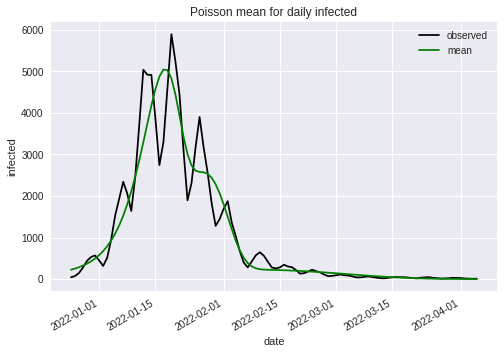

In [38]:
importlib.reload(initial_conditions)
from initial_conditions import *

# Get initial number of susceptibles
num_cum_omicron = G_sample_omicron.num_cum_mean
a_omicron=cum_hazard_omicron[1:]-cum_hazard_omicron[:-1]
a_omicron=np.concatenate(([0.0],a_omicron))
b_omicron=np.array([np.prod(1.0-a_omicron[:i+1]) for i in range(len(a_omicron))])
#b_omicron=np.concatenate(([1.0],b_omicron))

# Data for optimization
x_omicron=b_omicron[1:]-b_omicron[:-1]
y_omicron=num_cum_omicron[1:]-num_cum_omicron[:-1]
date_omicron=df_state_for_proof_omicron.Fecha.to_list()[1:]
Y0_omicron=num_cum_omicron[0]
P_omicron=pob
k0=10.0

# Optimization
N=5000
tol=np.finfo(float).eps**(1/2)
paramf_omicron=np.array([x_omicron,y_omicron]).T
mu_ref=0.1
f=plt.figure()
dic_results_asym_omicron=proof_levenberg_marquardt_nlls(R,J,k0,N,tol,mu_ref,paramf_omicron,P_omicron,Y0_omicron,date_omicron)
# Color EPS and PNG
f.set_rasterized(True)
f.savefig(ImageDir+'LM_omicron.eps',rasterized=True,dpi=300)
f.savefig(ImageDir+'LM_omicron.png')

# Gray PNG
img = Image.open(ImageDir+'LM_omicron.png').convert('LA')
img.save(ImageDir+'LM_omicron_gray.png')

# Gray EPS
img = Image.open(ImageDir+'LM_omicron.eps')
img.load(scale=4)   
img.convert("L").save(ImageDir+'LM_omicron_gray.eps')
plt.show()

Finally, we obtain Cox process for $\Omicron$ strain through simulation

In [39]:
from scipy.stats import poisson
'''
Poisson process baseline model
'''
k_omicron=np.squeeze(dic_results_asym_omicron['zk'])
# Poisson process
X_baseline_omicron = np.empty(len(days_omicron))
A_baseline_omicron = np.empty(len(days_omicron))
X_baseline_omicron[0] = num_cum_omicron[0]
A_baseline_omicron[0] = X_baseline_omicron[0]
for i in range(1, len(X_baseline_omicron)):
    if i <= len(num_cum_omicron)-1:
        mu_est = (P_omicron/k_omicron-A_baseline_omicron[i-1]) * \
            (cum_hazard_omicron[i]-cum_hazard_omicron[i-1])
    else:
        mu_est = (num_cum_omicron[0])*(cum_hazard_omicron[i]-cum_hazard_omicron[i-1])
    X_baseline_omicron[i] = poisson.rvs(mu=mu_est)
    A_baseline_omicron[i] = A_baseline_omicron[i-1]+X_baseline_omicron[i]

The growth curve in this case is

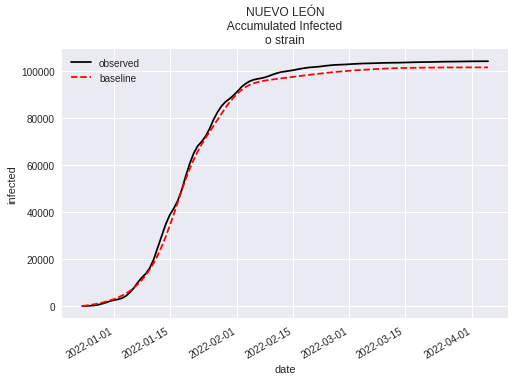

In [40]:
'''
Growth model omicron process
'''

date_state_omicron = df_state_for_proof_omicron.Fecha.to_list()

f=plt.figure()
plt.plot_date(date_state_omicron, num_cum_omicron, fmt='-', color='k', label='observed')
plt.plot_date(date_state_omicron, A_baseline_omicron, fmt='--', color='r', label='baseline')
plt.gcf().autofmt_xdate()
plt.gca().xaxis.set_major_formatter(date_format)
plt.legend()
plt.title(f'{state_for_proof}\n Accumulated Infected \n'+ r'o strain')
plt.xlabel('date')
plt.ylabel('infected')
# Color EPS and PNG
f.set_rasterized(True)
f.savefig(ImageDir+'accumulated_omicron.eps',rasterized=True,dpi=300)
f.savefig(ImageDir+'accumulated_omicron.png')

# Gray PNG
img = Image.open(ImageDir+'accumulated_omicron.png').convert('LA')
img.save(ImageDir+'accumulated_omicron_gray.png')

# Gray EPS
img = Image.open(ImageDir+'accumulated_omicron.eps')
img.load(scale=4)   
img.convert("L").save(ImageDir+'accumulated_omicron_gray.eps')
plt.show()

And the baseline daily infected curve is

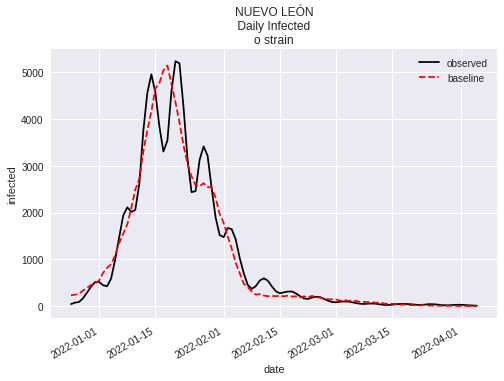

In [41]:
'''
Density omicron process
'''
from opt_baseline import mobile_mean
'''
Interpolation
'''
SOFT_PAR = 1
cs_density_baseline = inter_soft(
    days_omicron[1:], A_baseline_omicron[1:]-A_baseline_omicron[:-1], SOFT_PAR)
cs_density_obs = mobile_mean(
    days_omicron[1:], num_cum_omicron[1:]-num_cum_omicron[:-1], M_MEAN)

'''
Plotting
'''
f=plt.figure()
plt.plot_date(date_state_omicron[1:], cs_density_obs(
    days_omicron[1:]), fmt='k-', label='observed')
plt.plot_date(date_state_omicron[1:], cs_density_baseline(
    days_omicron[1:]), fmt='r--', label='baseline')
plt.gcf().autofmt_xdate()
plt.gca().xaxis.set_major_formatter(date_format)
plt.legend()
plt.title(f'{state_for_proof}\n Daily Infected \n'+ r'o strain')
plt.xlabel('date')
plt.ylabel('infected')
# Color EPS and PNG
f.set_rasterized(True)
f.savefig(ImageDir+'density_omicron.eps',rasterized=True,dpi=300)
f.savefig(ImageDir+'density_omicron.png')

# Gray PNG
img = Image.open(ImageDir+'density_omicron.png').convert('LA')
img.save(ImageDir+'density_omicron_gray.png')

# Gray EPS
img = Image.open(ImageDir+'density_omicron.eps')
img.load(scale=4)   
img.convert("L").save(ImageDir+'density_omicron_gray.eps')
plt.show()

Finally, we obtain deviance for baseline model in this case

In [42]:
from sklearn.metrics import mean_poisson_deviance

idx_pos_baseline_omicron=np.where(X_baseline_omicron>0)

deviance_error_baseline_omicron=mean_poisson_deviance(G_sample_omicron.num_dia_mean[idx_pos_baseline_omicron],X_baseline_omicron[idx_pos_baseline_omicron])
print('deviance omicron baseline: %.4f' %(deviance_error_baseline_omicron))

deviance omicron baseline: 107.6553


## Total process

We concatenate the last process and obtain the total dynamic in COVID-19 timeline

In [190]:
date_total=df_state_for_proof.Fecha.to_list()
days_total=df_state_for_proof.index.to_numpy()
cs_num_cum_total=mobile_mean(days_total,df_state_for_proof.CasosAcumulados.to_numpy(),M_MEAN)
cs_num_dia_total=mobile_mean(days_total,df_state_for_proof.CasosDiarios.to_numpy(),M_MEAN)

# Total process

# Density
X_baseline_total=np.concatenate((X_baseline_alpha,X_baseline_delta,X_baseline_omicron))
X_acc_cum_hazard_total=np.concatenate((X_acc_cum_hazard_alpha,X_acc_cum_hazard_delta,X_baseline_omicron))

# Growth model
A_baseline_total=np.concatenate((A_baseline_alpha,A_baseline_delta+A_baseline_alpha[-1],A_baseline_omicron+A_baseline_alpha[-1]+A_baseline_delta[-1]))

A_acc_cum_hazard_total=np.concatenate((A_acc_cum_hazard_alpha,A_acc_cum_hazard_delta+A_acc_cum_hazard_alpha[-1],A_baseline_omicron+A_acc_cum_hazard_alpha[-1]+A_acc_cum_hazard_delta[-1]))

We show the total growth curve

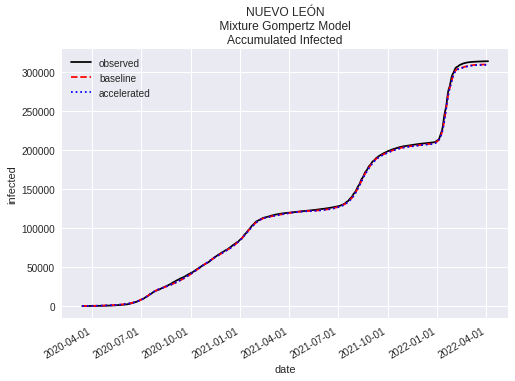

In [191]:
'''
Plotting
'''
f=plt.figure()
plt.plot_date(date_total,cs_num_cum_total(days_total), fmt='k-', label='observed')
plt.plot_date(date_total,A_baseline_total, fmt='r--', label='baseline')
plt.plot_date(date_total,A_acc_cum_hazard_total, fmt='b:', label='accelerated')
plt.gcf().autofmt_xdate()
plt.gca().xaxis.set_major_formatter(date_format)
plt.legend()
plt.title(f'{state_for_proof}\n Mixture Gompertz Model \nAccumulated Infected')
plt.xlabel('date')
plt.ylabel('infected')
# Color EPS and PNG
f.set_rasterized(True)
f.savefig(ImageDir+'accumulated_total.eps',rasterized=True,dpi=300)
f.savefig(ImageDir+'accumulated_total.png')

# Gray PNG
img = Image.open(ImageDir+'accumulated_total.png').convert('LA')
img.save(ImageDir+'accumulated_total_gray.png')

# Gray EPS
img = Image.open(ImageDir+'accumulated_total.eps')
img.load(scale=4)   
img.convert("L").save(ImageDir+'accumulated_total_gray.eps')
plt.show()

And the density is

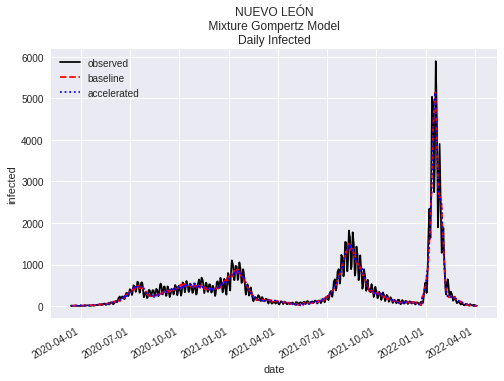

In [192]:
'''
Plotting
'''
f=plt.figure()
plt.plot_date(date_total,cs_num_dia_total(days_total), fmt='k-', label='observed')
plt.plot_date(date_total,X_baseline_total, fmt='r--', label='baseline')
plt.plot_date(date_total,X_acc_cum_hazard_total, fmt='b:', label='accelerated')
plt.gcf().autofmt_xdate()
plt.gca().xaxis.set_major_formatter(date_format)
plt.legend()
plt.title(f'{state_for_proof}\n Mixture Gompertz Model \nDaily Infected')
plt.xlabel('date')
plt.ylabel('infected')

# Color EPS and PNG
f.set_rasterized(True)
f.savefig(ImageDir+'density_total.eps',rasterized=True,dpi=300)
f.savefig(ImageDir+'density_total.png')

# Gray PNG
img = Image.open(ImageDir+'density_total.png').convert('LA')
img.save(ImageDir+'density_total_gray.png')

# Gray EPS
img = Image.open(ImageDir+'density_total.eps')
img.load(scale=4)   
img.convert("L").save(ImageDir+'density_total_gray.eps')
plt.show()

Finally, we get deviance for each model

In [193]:
from sklearn.metrics import mean_poisson_deviance

idx_pos_baseline_total=np.where(X_baseline_total>0)
idx_pos_acc_cum_hazard_total=np.where(X_acc_cum_hazard_total>0)

deviance_error_baseline_total=mean_poisson_deviance(cs_num_dia_total(days_total)[idx_pos_baseline_total],X_baseline_total[idx_pos_baseline_total])
deviance_error_acc_cum_hazard_total=mean_poisson_deviance(cs_num_dia_total(days_total)[idx_pos_acc_cum_hazard_total],X_acc_cum_hazard_total[idx_pos_acc_cum_hazard_total])
print('deviance total baseline : %.4f' %(deviance_error_baseline_total))
print('deviance total accelerated : %.4f' %(deviance_error_acc_cum_hazard_total))

deviance total baseline : 36.0367
deviance total accelerated : 35.7064


## Gompertz growth model

We are going to get the motivation plots. First, we obtain a sample

In [47]:
'''
Sample of each version
'''
G_sample = g_sample(df_state_for_proof, SamplesDir +
                       state_for_proof+'_v1.csv', SAMPLES, M_MEAN)
G_sample.main()
df_sample = G_sample.get_sampling_data()
df_sample['Rt'] = cs_rt(df_sample.tiempo.to_numpy())

Afterwards, we get growth model that we are looking for generalization.

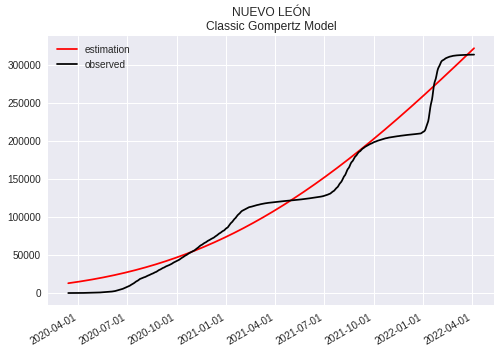

In [48]:
importlib.reload(initial_conditions)
from initial_conditions import gompertz_growth,neg_gomp_IC

G = [1]
data_sample_state = df_sample.copy()
data_state = df_state_for_proof.copy()
par_gomp_state_for_proof = neg_gomp_IC(
    G, data_state, data_sample_state, pob)[0]
par_gomp_state_for_proof['beta'] = np.exp(
    par_gomp_state_for_proof['gamma'])/par_gomp_state_for_proof['kappa']

plt.plot_date(date_total, gompertz_growth(par_gomp_state_for_proof,
                                     days_total), label='estimation',fmt='r-')
plt.plot_date(date_total, cs_num_cum_total(days_total), label='observed', fmt='k-')
plt.title(f'{state_for_proof}\nClassic Gompertz Model')
plt.legend()
plt.gcf().autofmt_xdate()
plt.gca().xaxis.set_major_formatter(date_format)
plt.show()

Then, we show the daily infected curve for classic Gompertz model

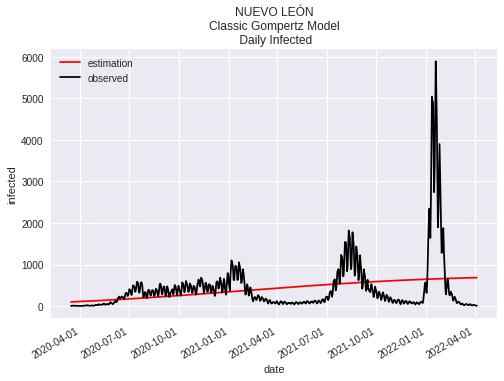

In [49]:
f=plt.figure()
plt.plot_date(date_total[1:], gompertz_growth(par_gomp_state_for_proof, days_total)[
         1:]-gompertz_growth(par_gomp_state_for_proof, days_total)[:-1], label='estimation', fmt='r-')
plt.plot_date(date_total[1:], cs_num_dia_total(days_total[1:]), label='observed', fmt='k-')
plt.title(f'{state_for_proof}\nClassic Gompertz Model\n Daily Infected')
plt.legend()
plt.gcf().autofmt_xdate()
plt.gca().xaxis.set_major_formatter(date_format)
plt.xlabel('date')
plt.ylabel('infected')
# Color EPS and PNG
f.set_rasterized(True)
f.savefig(ImageDir+'density_gompertz_model.eps',rasterized=True,dpi=300)
f.savefig(ImageDir+'density_gompertz_model.png')

# Gray PNG
img = Image.open(ImageDir+'density_gompertz_model.png').convert('LA')
img.save(ImageDir+'density_gompertz_model_gray.png')

# Gray EPS
img = Image.open(ImageDir+'density_gompertz_model.eps')
img.load(scale=4)   
img.convert("L").save(ImageDir+'density_gompertz_model_gray.eps')
plt.show()

## Useful results

Here we show some information that we got. First, we show the known $R_t$ range

In [50]:
range_dates_rt

(Timestamp('2020-03-02 00:00:00'), Timestamp('2022-01-23 00:00:00'))

Then, we show the carrying capacity of each process, fraction of susceptible population and total susceptible population deemed at the beginning of each strain.

In [51]:
# por cepa base

print("P_r alpha = %.4f, k_r = %.4f, alpha_k = %.4f" %(P_alpha,k_alpha,P_alpha/k_alpha))
print("P_r delta = %.4f, k_r = %.4f, alpha_k = %.4f" %(P_delta,k_delta,P_delta/k_delta))
print("P_r omicron = %.4f, k_r = %.4f, alpha_k = %.4f" %(P_omicron,k_omicron,P_omicron/k_omicron))

P_r alpha = 4653458.0000, k_r = 37.9349, alpha_k = 122669.6572
P_r delta = 2373263.5800, k_r = 27.5174, alpha_k = 86245.9701
P_r omicron = 4653458.0000, k_r = 45.7635, alpha_k = 101684.9340


In [187]:
# Acelerado
print("P_r alpha = %.4f, k_r_acc = %.4f, alpha_k_acc = %.4f" %(P_alpha,k_alpha_acc,P_alpha/k_alpha_acc))
print("P_r delta = %.4f, k_r_acc = %.4f, alpha_k_acc = %.4f" %(P_delta,k_delta_acc,P_delta/k_delta_acc))

P_r alpha = 4653458.0000, k_r_acc = 38.0352, alpha_k_acc = 122345.9848
P_r delta = 2373263.5800, k_r_acc = 27.6029, alpha_k_acc = 85978.9278


Total population is

In [188]:
print(f'{state_for_proof} population: {pob}')

NUEVO LEÓN population: 4653458.0


Last day observed

In [189]:
date_total[-1]

Timestamp('2022-04-05 00:00:00')

Accumulated number observed

In [54]:
print('Total accumulated alpha ',df_state_for_proof_alpha.iloc[-1]['CasosAcumulados'])
print('Total accumulated delta ',df_state_for_proof_delta.iloc[-1]['CasosAcumulados'])
print('Total accumulated omicron ',df_state_for_proof_omicron.iloc[-1]['CasosAcumulados'])

Total accumulated alpha  123385.0
Total accumulated delta  86671.0
Total accumulated omicron  104258.0


## Projection

We show an example of Gompertz tail estimation in order to complete that and do all the calculation presented.

We analyze $\Omicron$ strain case.

For using `Peaks-overs threshold method`, we need to smooth general sample dataset. We use a nonparametric method: Kernel Density estimation

In [55]:
importlib.reload(samples)
from samples import kde_sample

PATH_KDE_SAMPLE_OMICRON=SamplesDir+state_for_proof+'_kde_sample_omicron.csv'

kde_omicron=kde_sample(df_sample_omicron,PATH_KDE_SAMPLE_OMICRON,50000)
kde_omicron.main()

We estimate tail parameters with truncated smoothed sample

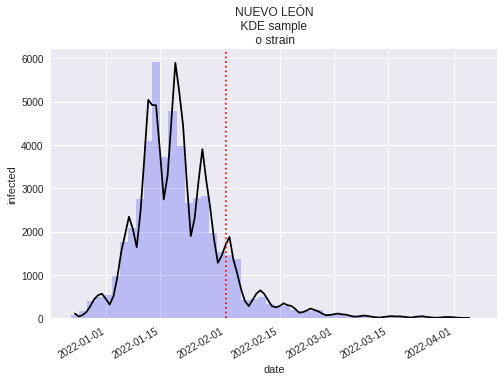

In [56]:
df_sample_kde_omicron=pd.read_csv(PATH_KDE_SAMPLE_OMICRON)
trun_par=int(num_umbral_date-num_omicron_rt_begin)
df_sample_kde_omicron_trun=df_sample_kde_omicron[df_sample_kde_omicron.tiempo<trun_par]
df_sample_kde_omicron_trun.to_csv(SamplesDir+state_for_proof+'_kde_sample_omicron_trun.csv')

'''
To date
'''
# Sample in date
sample_date_omicron_kde=[]
sample_num_kde_omicron=df_sample_kde_omicron.tiempo.to_numpy()
for i in range(len(sample_num_kde_omicron)):
    sample_date_omicron_kde.append(range_cepas_dates[2]+timedelta(days=int(sample_num_kde_omicron[i])))

# Visualization
plt.style.use('seaborn')
f=plt.figure()
plt.plot_date(df_state_for_proof_omicron.Fecha,G_sample_omicron.num_dia_mean,fmt='k-')
plt.hist(sample_date_omicron_kde,
         orientation='vertical', alpha=0.2, bins=50, color='b')
plt.axvline(umbral_date,linestyle='dotted',color='red')
plt.gcf().autofmt_xdate()
plt.gca().xaxis.set_major_formatter(date_format)
plt.title(f'{state_for_proof}\n KDE sample \n o strain')
plt.xlabel('date')
plt.ylabel('infected')
# Color EPS and PNG
f.set_rasterized(True)
f.savefig(ImageDir+'kde_sample_omicron.eps',rasterized=True,dpi=300)
f.savefig(ImageDir+'kde_sample_omicron.png')

# Gray PNG
img = Image.open(ImageDir+'kde_sample_omicron.png').convert('LA')
img.save(ImageDir+'kde_sample_omicron_gray.png')

# Gray EPS
img = Image.open(ImageDir+'kde_sample_omicron.eps')
img.load(scale=4)   
img.convert("L").save(ImageDir+'kde_sample_omicron_gray.eps')
plt.show()

We estimate Pareto-generalized parameters 

In [57]:
'''
Parametros ajustados para la DGP
'''
p_pareto=[14.0140216, -0.7354553]

'''
Umbral seleccionado
'''
u= 30

'''
Susceptibles
'''
S0=P_omicron


num_dia_omicron_trun=G_sample_omicron.num_dia_mean[:trun_par]
num_cum_omicron_trun=G_sample_omicron.num_cum_mean[:trun_par]
days_omicron_trun=days_omicron[:trun_par]


# Indice con el el valor u para el dia
day_final=days_omicron[-1]

Finally, we present the tail estimation and we contrast with observed data

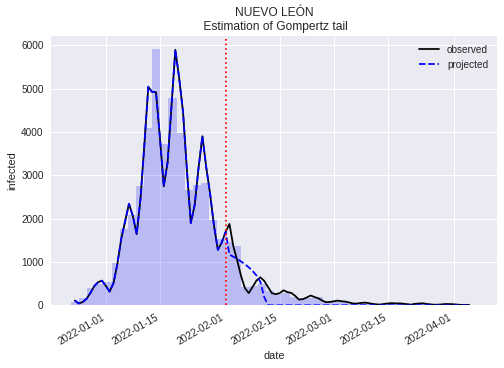

In [194]:
from scipy.stats import genpareto

'''
Proyeccion de los infectados
'''

# Supervivencia
sf_general_omicron,sf_comp_omicron=MG_baseline_omicron.sf(days_omicron)

def projection(trun_par,day_final):
    t=np.arange(trun_par-u,day_final-u)
    d_pareto=genpareto.pdf(t,c=p_pareto[1],scale=p_pareto[0])
    sf_u=1.0-(G_sample_omicron.num_cum[u]/(P_omicron/k_omicron))
    infected_pro=G_sample_omicron.num_cum[u]*sf_u*d_pareto
    num_dia_omicron_proj=np.concatenate((num_dia_omicron_trun,infected_pro))
    return num_dia_omicron_proj

num_dia_omicron_trun_proj=projection(trun_par,day_final)

'''
Visualización de la proyeccion vs los observados
'''
f=plt.figure()
plt.plot_date(date_state_omicron,G_sample_omicron.num_dia_mean,fmt='k-',label='observed')
plt.plot_date(date_state_omicron,num_dia_omicron_trun_proj,fmt='b--',label='projected')
plt.hist(sample_date_omicron_kde,orientation='vertical', alpha=0.2, bins=50, color='b')
plt.axvline(umbral_date,linestyle='dotted',color='red')
plt.gcf().autofmt_xdate()
plt.gca().xaxis.set_major_formatter(date_format)
plt.legend()
plt.title(f'{state_for_proof}\n Estimation of Gompertz tail')
plt.xlabel('date')
plt.ylabel('infected')
# Color EPS and PNG
f.set_rasterized(True)
f.savefig(ImageDir+'tail_gompertz_model.eps',rasterized=True,dpi=300)
f.savefig(ImageDir+'tail_gompertz_model.png')

# Gray PNG
img = Image.open(ImageDir+'tail_gompertz_model.png').convert('LA')
img.save(ImageDir+'tail_gompertz_model_gray.png')

# Gray EPS
img = Image.open(ImageDir+'tail_gompertz_model.eps')
img.load(scale=4)   
img.convert("L").save(ImageDir+'tail_gompertz_model_gray.eps')
plt.show()